In [1]:
from __future__ import division
import os
import numpy as np
import pprint
import tensorflow as tf
import tensorflow.contrib.slim as slim
import pickle, csv
import sys
import time
import datetime
import pandas as pd
import seaborn as sns
#import nilearn
import nibabel as nib
from scipy.ndimage.morphology import binary_dilation
sys.path.append('..')
from utils import *
from model import UNet3D
from skimage import measure
import collections
#
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Project dir
proj_dir = '/data/ipl/scratch03/nikhil/skull_seg/'
#tf.__version__

# Model training

In [3]:
# FLAGS
flags = tf.app.flags
flags.DEFINE_integer("epoch", 1, "Epoch to train [4]")
flags.DEFINE_string("patch_dir", proj_dir + "data/patches/p64/", "Directory of the training data [patches]")
flags.DEFINE_string("aug_dir", proj_dir + "data/patches/p64_flip/", "Directory of the augmented training data [patches]")
flags.DEFINE_bool("split_train", False, "Whether to split the train data into train and val [False]")
flags.DEFINE_string("train_data_dir", proj_dir + "data/input/", "Directory of the train data ")
flags.DEFINE_string("deploy_data_dir", proj_dir + "data/input/", "Directory of the test data")
flags.DEFINE_string("deploy_output_dir", proj_dir + "data/predictions/", "Directory name of the output data [output]")
flags.DEFINE_integer("batch_size", 10, "Batch size [1]")
flags.DEFINE_integer("seg_features_root",32, "Number of features in the first filter in the seg net [48]")
flags.DEFINE_integer("conv_size", 3, "Convolution kernel size in encoding and decoding paths [3]")
flags.DEFINE_integer("layers", 1, "Encoding and deconding layers [3]")
flags.DEFINE_string("loss_type", "dice", "Loss type in the model [cross_entropy]")
flags.DEFINE_float("dropout", 0.5, "Drop out ratio [0.5]")
flags.DEFINE_string("checkpoint_dir", "checkpoint3", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("log_dir", "logs3", "Directory name to save logs [logs]")
flags.DEFINE_boolean("train", True, "True for training, False for deploying [False]")
flags.DEFINE_boolean("run_seg", True, "True if run segmentation [True]")

flags.DEFINE_string('f', '', 'kernel') # Needed for jupyter to work 
FLAGS = flags.FLAGS #flags.FLAGS

In [4]:
# Input patches 
orig_patch_paths = [os.path.join(FLAGS.patch_dir, name) for name in os.listdir(FLAGS.patch_dir)
                  if '.DS' not in name]
aug_patch_paths = [os.path.join(FLAGS.patch_dir, name) for name in os.listdir(FLAGS.patch_dir)
                  if '.DS' not in name]

sub_ids = [os.path.basename(i) for i in orig_patch_paths]

# check if subject order is same 
print(zip(sub_ids,[os.path.basename(i) for i in aug_patch_paths]))

[('sub_53', 'sub_53'), ('sub_04', 'sub_04'), ('sub_47', 'sub_47'), ('sub_46', 'sub_46'), ('sub_45', 'sub_45'), ('sub_18', 'sub_18'), ('sub_06', 'sub_06'), ('sub_38', 'sub_38'), ('sub_48', 'sub_48'), ('sub_43', 'sub_43'), ('sub_44', 'sub_44'), ('sub_20', 'sub_20'), ('sub_51', 'sub_51'), ('sub_50', 'sub_50'), ('sub_52', 'sub_52'), ('sub_05', 'sub_05'), ('sub_49', 'sub_49'), ('sub_54', 'sub_54'), ('sub_42', 'sub_42'), ('sub_41', 'sub_41')]


In [10]:
# Set train-test paths 
n_sampx = 20
train_sampx = 10
test_sampx = 10

training_paths = orig_patch_paths[:train_sampx] + aug_patch_paths[:train_sampx]
testing_paths = orig_patch_paths[n_sampx-test_sampx:] # don't need to test with aug data

training_ids = sub_ids[train_sampx:]
testing_ids = sub_ids[:n_sampx-test_sampx]

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)

if not os.path.exists(FLAGS.log_dir):
    os.makedirs(FLAGS.log_dir)

In [6]:
# training bookkeeping
trained_model_stats = pd.DataFrame(columns=['run_index','net_structure','training_params',
                                            'stage','acc','dice','loss'])
run_index = 'UNET_201' #101: p64, 201: p32
input_size = 32
class_weights = np.array([0.9,0.1])
net_structure = '{}_{}_{}'.format(input_size,FLAGS.layers,FLAGS.seg_features_root)
training_params = '{}_{}_{}'.format(FLAGS.epoch,FLAGS.loss_type,FLAGS.batch_size)

train_network = True
test_network = False

start_time = datetime.datetime.now()
print(start_time)

if FLAGS.run_seg:
    run_config = tf.ConfigProto()
    with tf.Session(config=run_config) as sess:
        unet = UNet3D(sess, checkpoint_dir=FLAGS.checkpoint_dir, log_dir=FLAGS.log_dir, training_paths=training_paths,
                      testing_paths=testing_paths, batch_size=FLAGS.batch_size, layers=FLAGS.layers,
                      features_root=FLAGS.seg_features_root, conv_size=FLAGS.conv_size,
                      dropout=FLAGS.dropout, loss_type=FLAGS.loss_type, class_weights=class_weights)

        if train_network:
            model_vars = tf.trainable_variables()
            slim.model_analyzer.analyze_vars(model_vars, print_info=True)

            train_config = {}
            train_config['epoch'] = FLAGS.epoch

            train_metrics,test_metrics = unet.train(train_config)
            
            #Save the perfromance at the end of training
            train_end_acc = train_metrics['acc'][-1]
            train_end_dice = train_metrics['dice'][-1]
            train_end_loss = train_metrics['loss'][-1]
            test_end_acc = test_metrics['acc'][-1]
            test_end_dice = test_metrics['dice'][-1]
            test_end_loss = test_metrics['loss'][-1]
            
            trained_model_stats.loc[0] = [run_index, net_structure, training_params, 'train', 
                                          train_end_acc, train_end_dice, train_end_loss]
            trained_model_stats.loc[1] = [run_index, net_structure, training_params, 'test',
                                          test_end_acc, test_end_dice, test_end_loss]
            
        print('Training complete')
        
        if test_network:
            print('\nTesting trained model with actual MR image')
            if not os.path.exists(FLAGS.deploy_output_dir):
                os.makedirs(FLAGS.deploy_output_dir)

            unet.deploy(FLAGS.deploy_data_dir, FLAGS.deploy_output_dir)
            print('Test complete. Output at {}'.format(FLAGS.deploy_output_dir))
        
    tf.reset_default_graph()

end_time = datetime.datetime.now()
print('start: {}, end: {}'.format(start_time, end_time))

2018-11-19 14:54:29.532625
encoding...
decoding...
Using class weights: [ 0.9  0.1]
---------
Variables: name (type shape) [size]
---------
encoding0/w1:0 (float32_ref 3x3x3x1x32) [864, bytes: 3456]
encoding0/b1:0 (float32_ref 32) [32, bytes: 128]
encoding0/batch_normalization/beta:0 (float32_ref 32) [32, bytes: 128]
encoding0/batch_normalization/gamma:0 (float32_ref 32) [32, bytes: 128]
encoding0/w2:0 (float32_ref 3x3x3x32x32) [27648, bytes: 110592]
encoding0/b2:0 (float32_ref 32) [32, bytes: 128]
encoding0/batch_normalization_1/beta:0 (float32_ref 32) [32, bytes: 128]
encoding0/batch_normalization_1/gamma:0 (float32_ref 32) [32, bytes: 128]
bottom/w1:0 (float32_ref 3x3x3x32x64) [55296, bytes: 221184]
bottom/b1:0 (float32_ref 64) [64, bytes: 256]
bottom/batch_normalization/beta:0 (float32_ref 64) [64, bytes: 256]
bottom/batch_normalization/gamma:0 (float32_ref 64) [64, bytes: 256]
bottom/w2:0 (float32_ref 3x3x3x64x64) [110592, bytes: 442368]
bottom/b2:0 (float32_ref 64) [64, bytes: 25

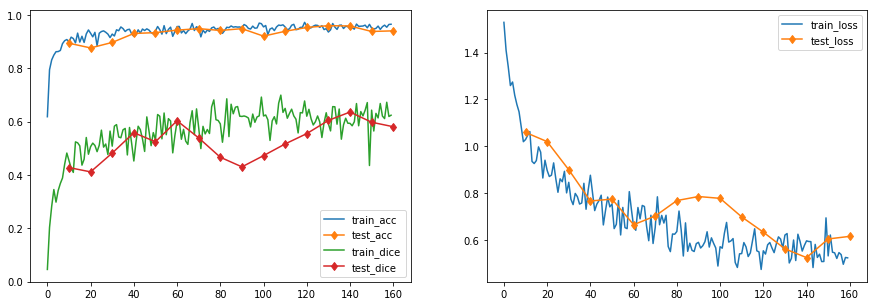

In [7]:
# Simple plots (tensorboard alternative)

train_acc = np.array(train_metrics['acc'])
train_dice = np.array(train_metrics['dice'])
train_loss = np.array(train_metrics['loss'])
test_acc = np.array(test_metrics['acc'])
test_dice = np.array(test_metrics['dice'])
test_loss = np.array(test_metrics['loss'])

test_interval = 10
steps = range(test_interval,len(train_acc)+test_interval,test_interval)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_acc,label='train_acc')
plt.plot(steps,test_acc,'-d',label='test_acc')

plt.plot(train_dice,label='train_dice')
plt.plot(steps,test_dice,'-d',label='test_dice')

plt.legend()
plt.subplot(1,2,2)
plt.plot(train_loss,label='train_loss')
plt.plot(steps,test_loss,'-d',label='test_loss')
plt.legend()

In [8]:
trained_model_stats

,run_index,net_structure,training_params,stage,acc,dice,loss
0,UNET_201,32_1_32,1_dice_10,train,0.965964,0.624478,0.524973
1,UNET_201,32_1_32,1_dice_10,test,0.941106,0.581277,0.616651


In [12]:
# List of subjects
model_perf = pd.DataFrame(columns=['run_index','net_structure','training_params',
                                   'sub_idx','stage','acc','dice','dice_clean'])

subject_dir = proj_dir + 'data/input/'
sub_dirs = os.listdir(subject_dir)
sub_idx = []
for d in sub_dirs:
    sub_idx.append(d.split('_')[1])

In [13]:
# check segmented data
thesh = 0.5
min_blob_size = 100
for i, idx in enumerate(sub_idx):
    img = nib.load(proj_dir + 'data/input/sub_{}/t1w_{}.nii.gz'.format(idx,idx)).get_fdata()
    img_masked = nib.load(proj_dir + 'data/input/sub_{}/t1w_{}_masked.nii.gz'.format(idx,idx)).get_fdata()
    img_label = nib.load(proj_dir + 'data/input/sub_{}/skull_{}_seg.nii.gz'.format(idx,idx)).get_fdata()
    img_pred = np.load(proj_dir + 'data/predictions/sub_{}_probs.npy'.format(idx))
    img_pred_label = img_pred[:,:,:,1]> thesh
    
    # perf metrics
    acc = np.sum(img_label==img_pred_label)/len(img_label.ravel())
    d = dice(img_label,img_pred_label)
    img_pred_label_clean = clean_predicted_seg(img_pred_label,min_blob_size)
    d_clean = dice(img_label,img_pred_label_clean)
    
    if 'sub_{}'.format(idx) in training_ids:
        stage = 'train'
    else:
        stage = 'test'

    model_perf.loc[i] = [run_index, net_structure, training_params, idx, stage, acc, d, d_clean]

Label Counter({False: 7914265, True: 615756})
Number of blobs: 7
Cleaned Label Counter({False: 7914306, True: 615715})
Label Counter({False: 7914263, True: 615758})
Number of blobs: 7
Cleaned Label Counter({False: 7914304, True: 615717})
Label Counter({False: 7914247, True: 615774})
Number of blobs: 7
Cleaned Label Counter({False: 7914288, True: 615733})
Label Counter({False: 7914248, True: 615773})
Number of blobs: 7
Cleaned Label Counter({False: 7914289, True: 615732})
Label Counter({False: 7914257, True: 615764})
Number of blobs: 7
Cleaned Label Counter({False: 7914298, True: 615723})
Label Counter({False: 7914244, True: 615777})
Number of blobs: 7
Cleaned Label Counter({False: 7914285, True: 615736})
Label Counter({False: 7914245, True: 615776})
Number of blobs: 7
Cleaned Label Counter({False: 7914286, True: 615735})
Label Counter({False: 7914257, True: 615764})
Number of blobs: 7
Cleaned Label Counter({False: 7914298, True: 615723})
Label Counter({False: 7914236, True: 615785})
Nu

In [14]:
#model_perf.to_csv(proj_dir + 'perf_{}_2.csv'.format(run_index))
model_perf

,run_index,net_structure,training_params,sub_idx,stage,acc,dice,dice_clean
0,UNET_201,32_1_32,1_dice_10,53,test,0.962275,0.682121,0.682115
1,UNET_201,32_1_32,1_dice_10,04,test,0.954798,0.575612,0.575632
2,UNET_201,32_1_32,1_dice_10,47,test,0.962873,0.710379,0.710402
3,UNET_201,32_1_32,1_dice_10,46,test,0.954437,0.581762,0.581777
4,UNET_201,32_1_32,1_dice_10,45,test,0.962606,0.678766,0.678792
5,UNET_201,32_1_32,1_dice_10,18,test,0.956807,0.607055,0.607061
6,UNET_201,32_1_32,1_dice_10,06,test,0.967978,0.743293,0.743317
7,UNET_201,32_1_32,1_dice_10,38,test,0.954946,0.586491,0.586504
8,UNET_201,32_1_32,1_dice_10,48,test,0.972169,0.798189,0.798190
9,UNET_201,32_1_32,1_dice_10,43,test,0.958029,0.636405,0.636409


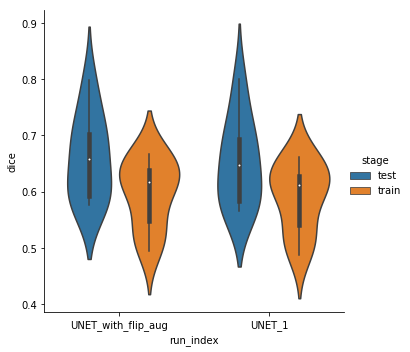

In [17]:
# Model perf plots:
model_perf['run_index'] = np.tile('UNET_with_flip_aug',len(model_perf))
prev_perf = pd.read_csv(proj_dir + 'perf_UNET_1.csv')
compare_model_perf = model_perf.append(prev_perf)
sns.catplot(y='dice',x='run_index',data=compare_model_perf,kind='violin',hue='stage')

In [44]:
np.unique(img_masked.ravel())

array([  0.        ,  81.17577362,  81.17578125, ...,  81.54618073,
        81.5462265 ,  81.54637909])

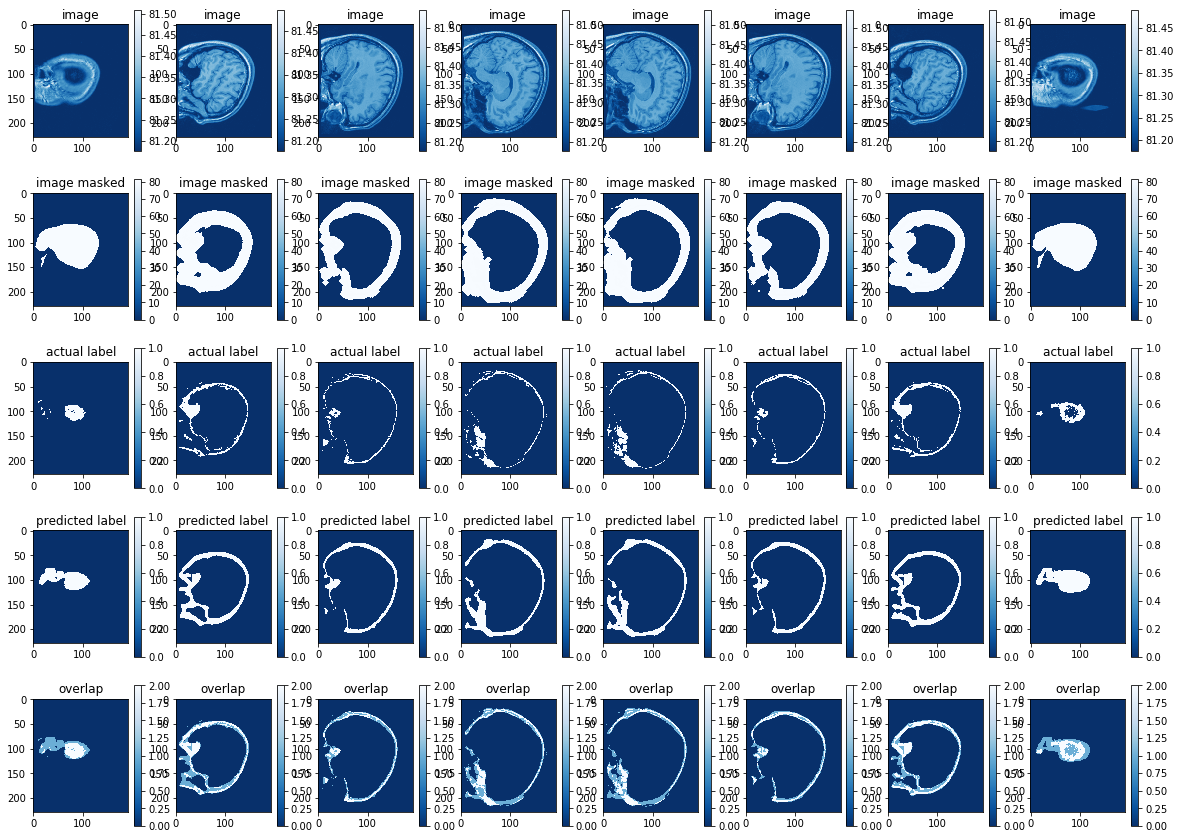

In [48]:
# Sample slice plot for predictions
plt.figure(figsize=(20,15))
r = 5
c = 8
img_plane = 0
n_slices = img.shape[img_plane]//(c+1)

slices = range(1,img.shape[img_plane],n_slices)

for i, s in enumerate(slices[1:-1]):
    img_slice = img[s,:,:]
    plt.subplot(r,c,i+1)
    seg_plot = plt.imshow(img_slice);
    seg_plot.set_cmap("Blues_r")
    plt.colorbar()
    plt.title('image')

for i, s in enumerate(slices[1:-1]):
    img_masked_slice = img_masked[s,:,:]
    plt.subplot(r,c,c+i+1)
    seg_plot = plt.imshow(img_masked_slice);
    seg_plot.set_cmap("Blues_r")
    plt.colorbar()
    plt.title('image masked')

for i, s in enumerate(slices[1:-1]):
    img_label_slice = img_label[s,:,:]
    plt.subplot(r,c,2*c+i+1)
    seg_plot = plt.imshow(img_label_slice);
    seg_plot.set_cmap("Blues_r")
    plt.colorbar()
    plt.title('actual label')

for i, s in enumerate(slices[1:-1]):
    img_pred_slice = img_pred_label_clean[s,:,:]
    plt.subplot(r,c,3*c+i+1)
    seg_plot = plt.imshow(img_pred_slice.astype(int));
    seg_plot.set_cmap("Blues_r")
    plt.colorbar()
    plt.title('predicted label')
    
for i, s in enumerate(slices[1:-1]):
    label_pred_overlap_slice = img_label[s,:,:] + img_pred_label_clean[s,:,:]
    plt.subplot(r,c,4*c+i+1)
    seg_plot = plt.imshow(label_pred_overlap_slice.astype(int));
    seg_plot.set_cmap("Blues_r")
    plt.colorbar()
    plt.title('overlap')

In [9]:
"""
_dice.py : Dice coefficient for comparing set similarity.

"""

import numpy as np


def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.

    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.

    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.

    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

def clean_predicted_seg(pred_seg,min_blob_size):
    img_pred_label_clean = pred_seg.copy()
    print('Label {}'.format(collections.Counter(img_pred_label_clean.ravel())))
    blobs_labels = measure.label(img_pred_label_clean,neighbors=8, background=0)
    print('Number of blobs: {}'.format(len(np.unique(blobs_labels))))
    label_count = collections.Counter(blobs_labels.ravel())

    for key in label_count.keys():
        if label_count[key] < min_blob_size:
            img_pred_label_clean[blobs_labels==key] = False

    print('Cleaned Label {}'.format(collections.Counter(img_pred_label_clean.ravel())))

    return img_pred_label_clean